<a href="https://colab.research.google.com/github/reubyTuesday/Math509RealEstate/blob/main/Boston_Dataset_MATH509_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_openml


Populating the interactive namespace from numpy and matplotlib


# Load data from the source

In [ ]:
# Define the path to the dataset
path_to_data = 'https://drive.google.com/uc?id=1hWB66jk3g37_Qq53UHx_lDG2iIQCmNkQ'

# Read the dataset without assuming a header
data = pd.read_csv(path_to_data, delim_whitespace=True, header=None)

# Define column names (ensure they match the dataset)
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Assign column names to the DataFrame
data.columns = column_names

# Delete the 'B' column
data = data.drop('B', axis=1)

# Display the entire dataset
# print(data)

<ipython-input-2-3e2bfc7f4e64>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(path_to_data, delim_whitespace=True, header=None)


# Creating Scatter plot

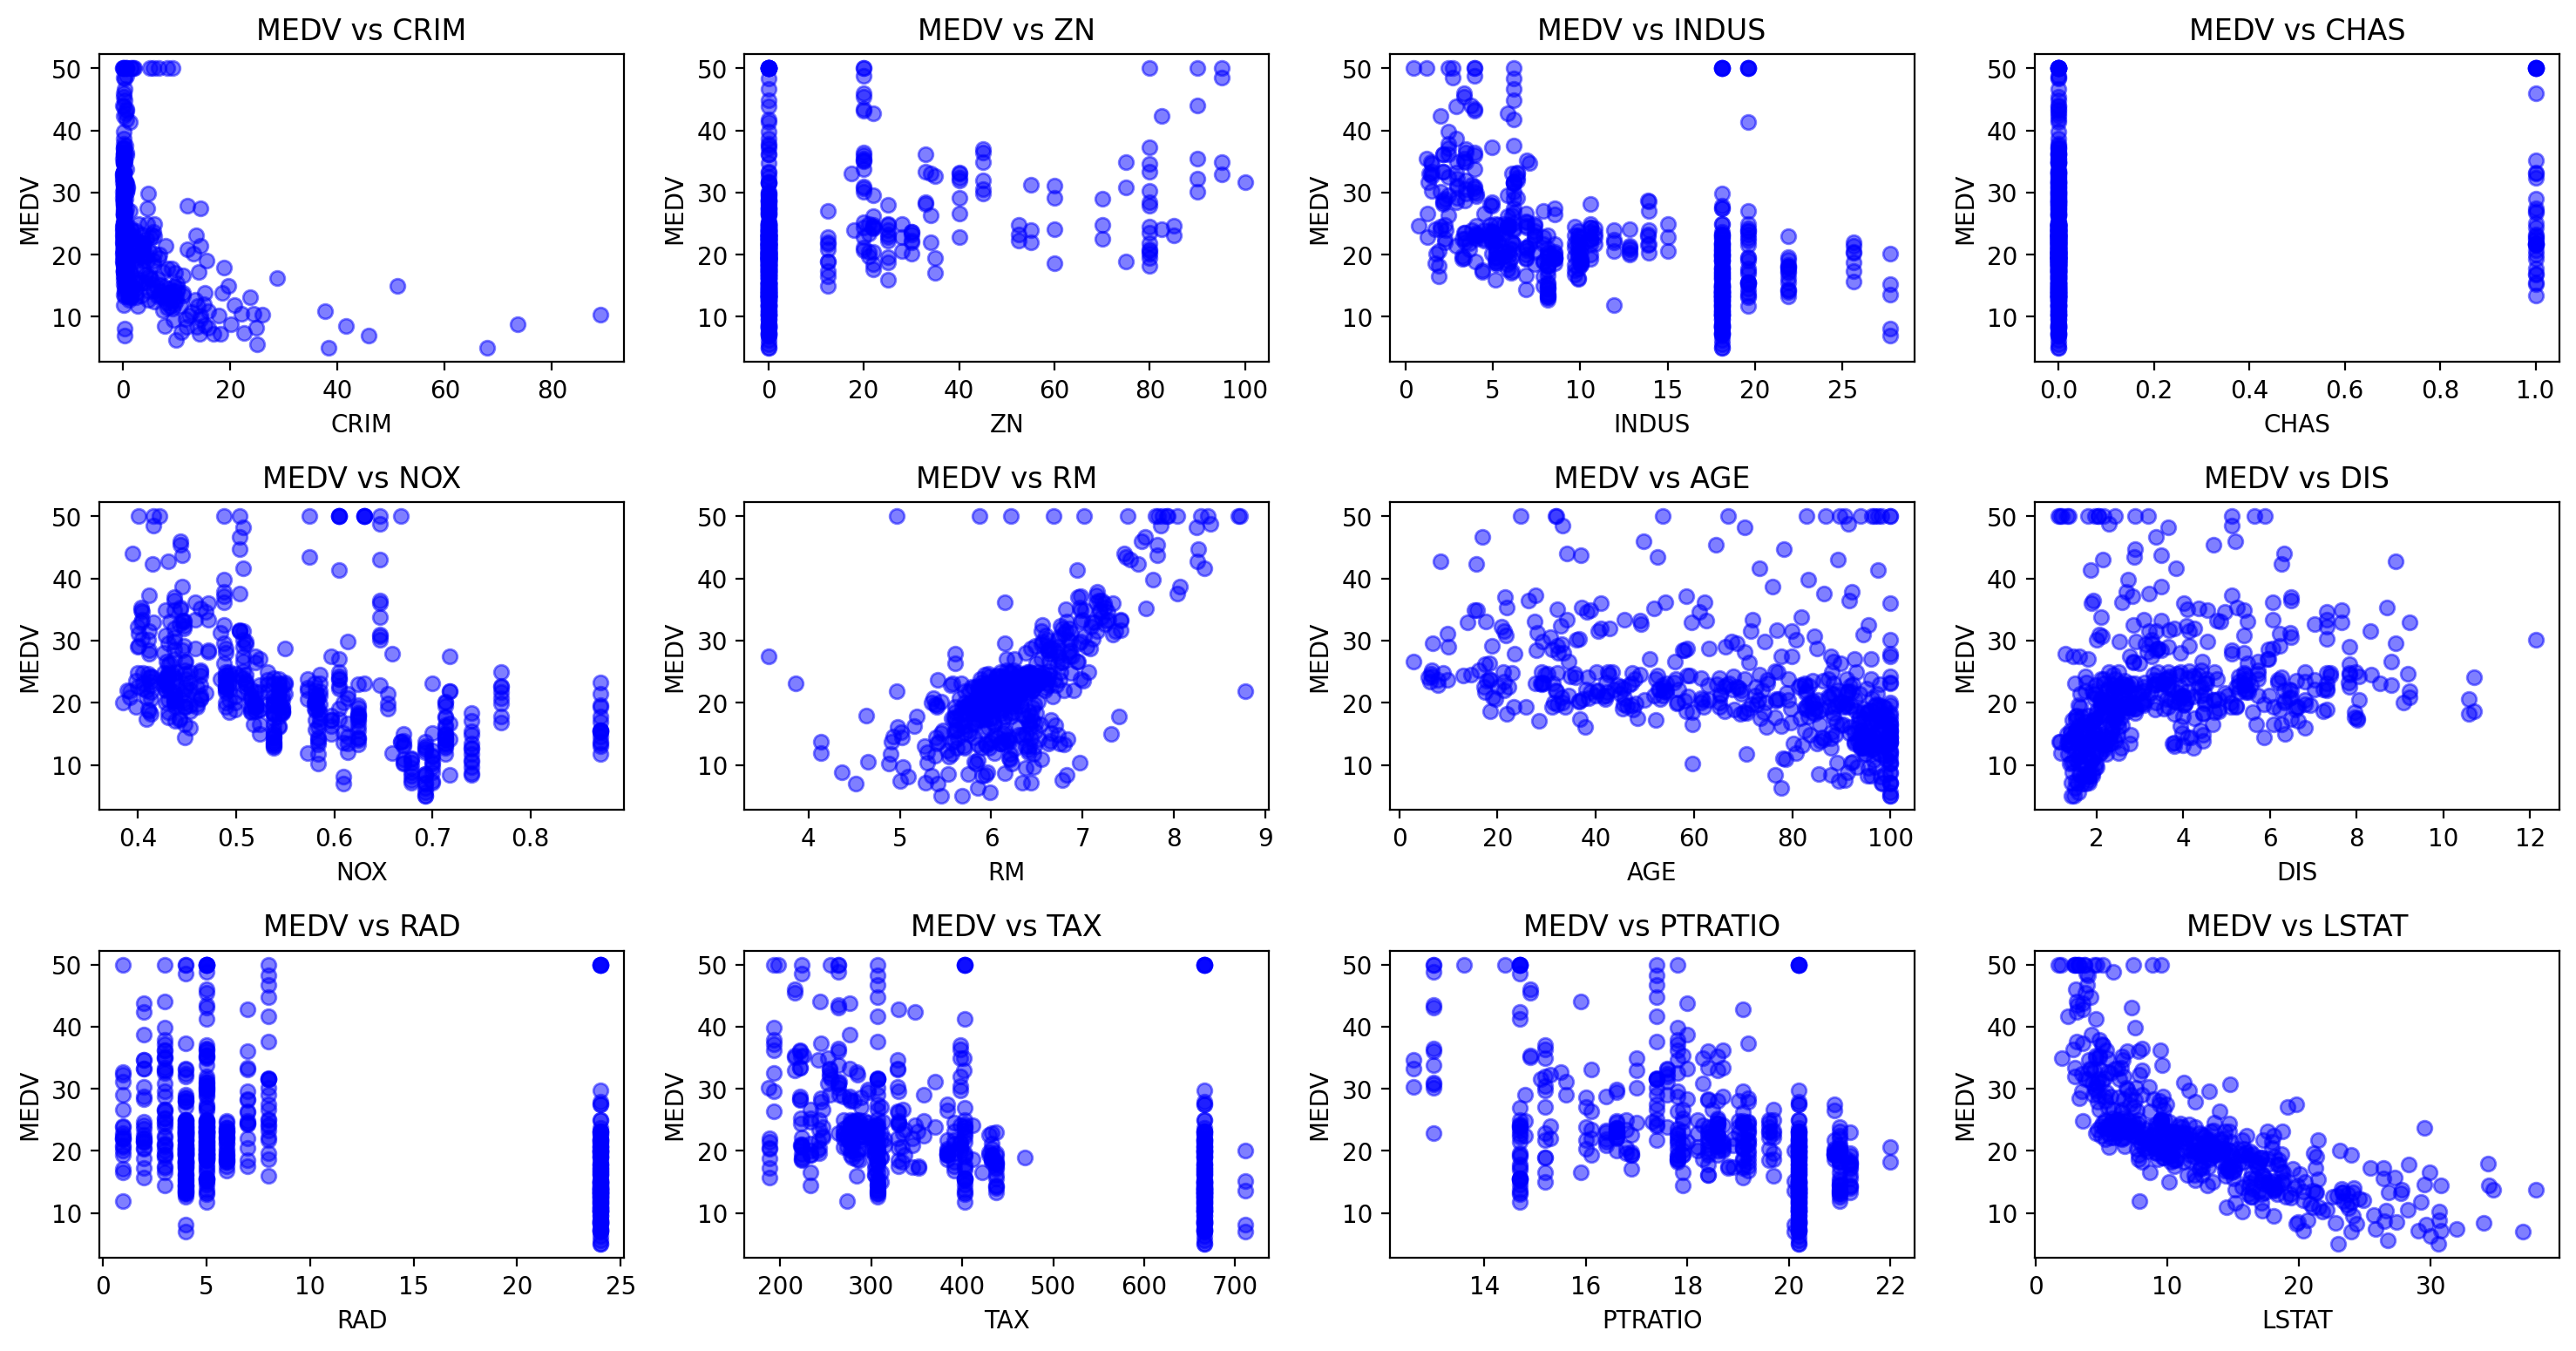

In [ ]:
# Creating scatter plots

# Define the response variable (target)
y_response = data['MEDV']

# Create scatter plots for each predictor against the target variable
plt.figure(figsize=(15, 10))  # Set figure size

for i, col in enumerate(data.columns[:-1]):  # Exclude MEDV from predictors
    plt.subplot(4, 4, i + 1)  # Create subplots in a 4x4 grid
    plt.scatter(data[col], y_response, color='blue', alpha=0.5)  # Set blue color
    plt.xlabel(col)
    plt.ylabel('MEDV')
    plt.title(f'MEDV vs {col}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


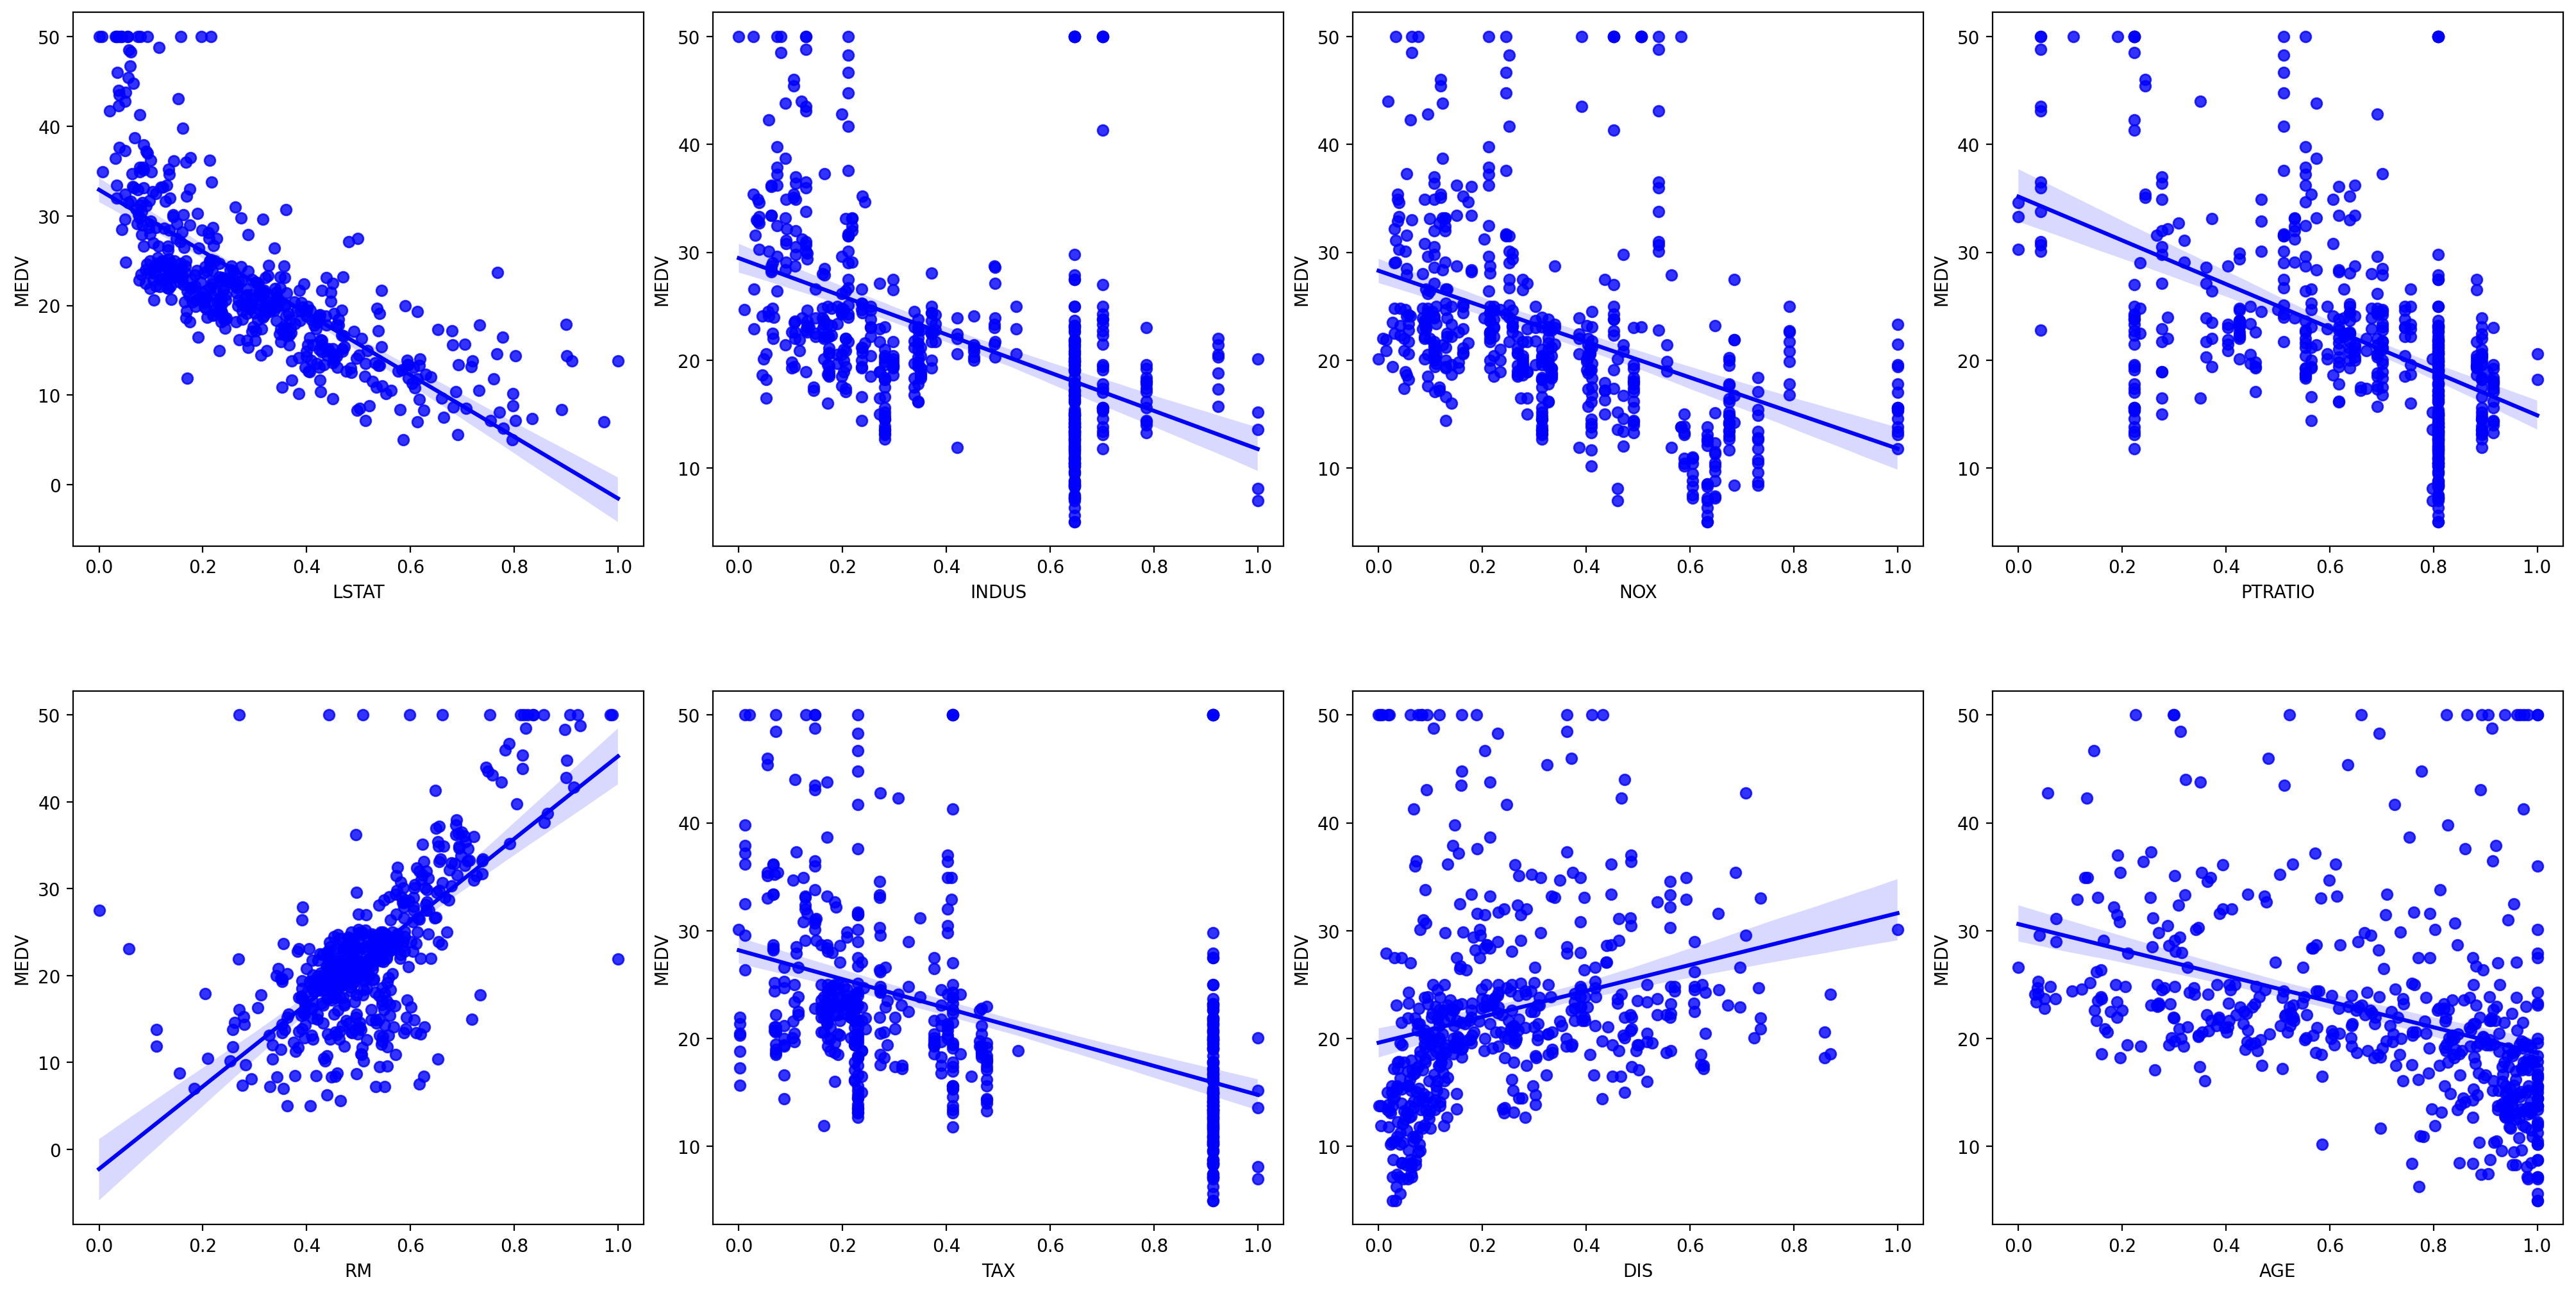

In [ ]:
from sklearn import preprocessing
import seaborn as sns # import seaborn here as well.
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i], color='blue')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# Crate Boxplot to investigate if there are outliers.

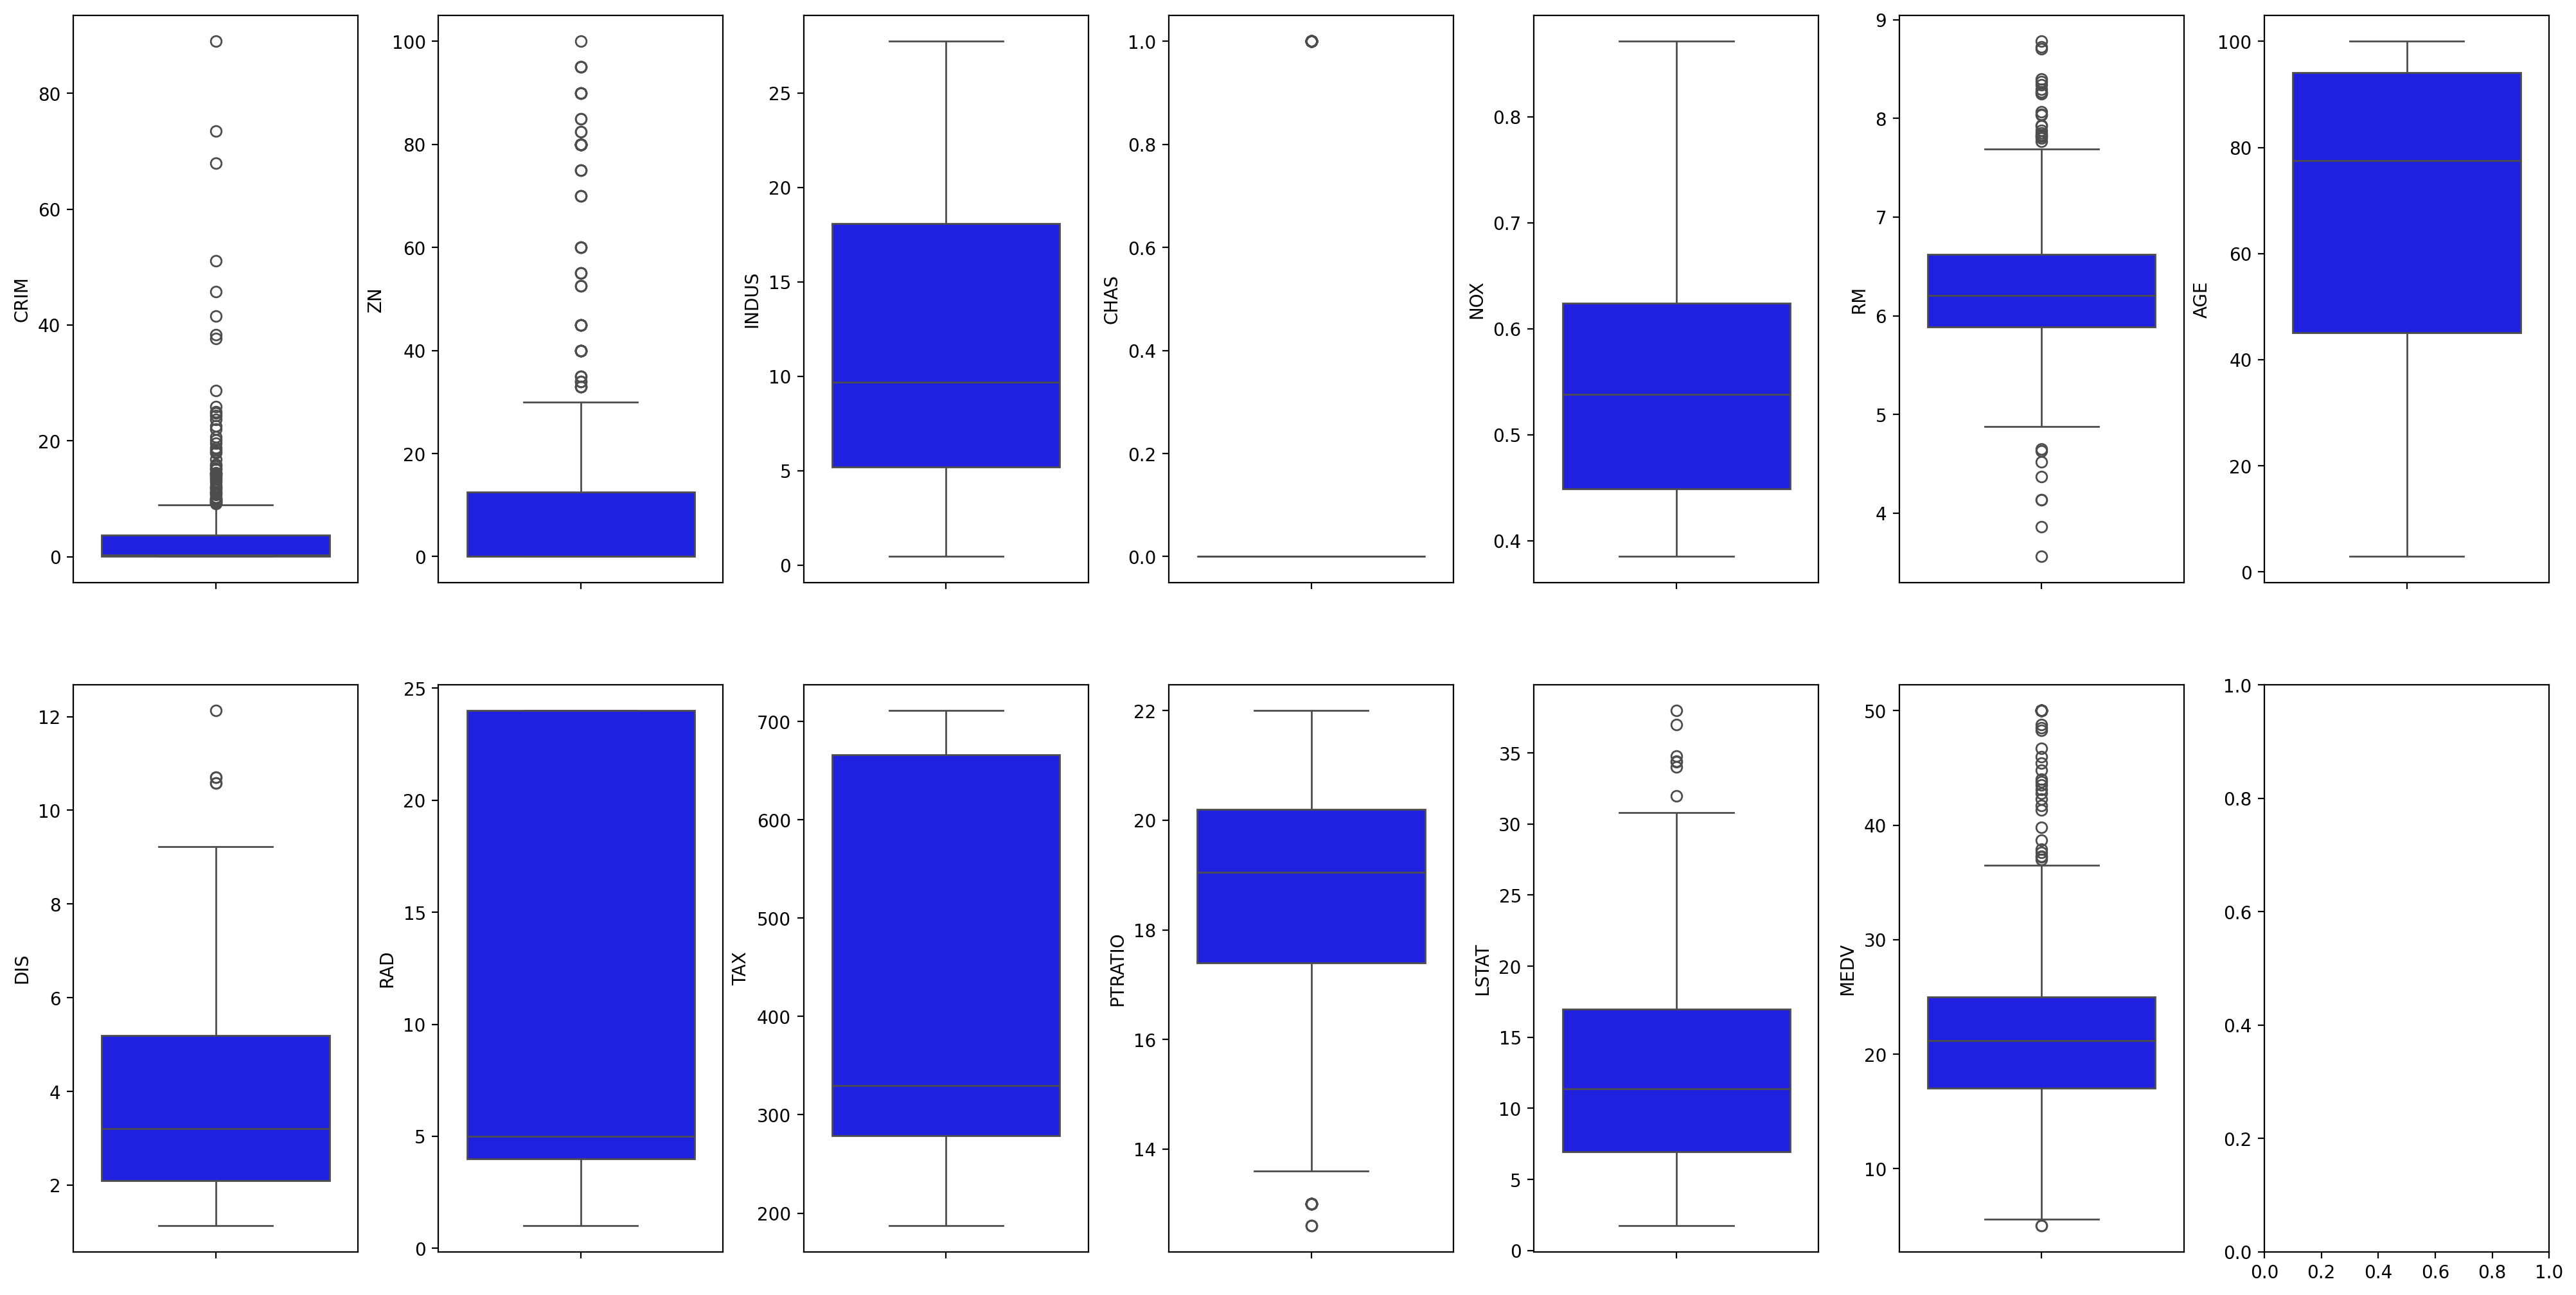

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index], color='blue')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [ ]:
data.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12.653063   
std     28.148861    2.105710    8.707259  168.537116    2.164946    7.141062   
min      2.900000    1.129600    1.000000  187.000000   12.600000    1.730000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000    6.950000   
50%     77.500000    3.207450    5.000000  330.000000   19.050000   11.360000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000   16.955000   
max    100.000000   12.126500   24.000000  711.000000   22.000000   37.970000   

             MEDV  
count  506.000000  
mean    22.532806  
std      9.197104  
min      5.000000  
25%     17.025000  
50%     21.200000  
75%     25.000000  
max     50.000000

# Applying mean imputation to polish the outliers

In [ ]:
# Compute 95th percentile threshold
threshold1 = data['CRIM'].quantile(0.95)

# Replace values greater than the 95th percentile with the threshold value
data.loc[data['CRIM'] > threshold1, 'CRIM'] = data.loc[data['CRIM'] <=threshold1, 'CRIM'].mean()

# Compute 95th percentile threshold
threshold2 = data['ZN'].quantile(0.85)

# Replace values greater than the 95th percentile with the threshold value
data.loc[data['ZN'] > threshold2, 'ZN'] = data.loc[data['ZN'] <=threshold2, 'ZN'].mean()

# Compute 95th percentile threshold
threshold3 = data['MEDV'].quantile(0.95)

# Replace values greater than the 95th percentile with the threshold value
data.loc[data['MEDV'] > threshold3, 'MEDV'] = data.loc[data['MEDV'] <=threshold3, 'MEDV'].mean()

display(data.describe())

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     2.092157    2.820602   11.136779    0.069170    0.554695    6.284634   
std      3.553630    6.654388    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      2.092157    2.820602   18.100000    0.000000    0.624000    6.623500   
max     15.575700   28.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12.653063   
std     28.148861    2.105710    8.707259  168.537116    2.164946    7.141062   
min      2.900000    1.129600    1.000000  187.000000   12.600000    1.730000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000    6.950000   
50%     77.500000    3.207450    5.000000  330.000000   19.050000   11.360000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000   16.955000   
max    100.000000   12.126500   24.000000  711.000000   22.000000   37.970000   

             MEDV  
count  506.000000  
mean    21.128750  
std      6.917394  
min      5.000000  
25%     17.025000  
50%     21.128750  
75%     24.100000  
max     43.100000

# Creating Boxplot after mean imputation

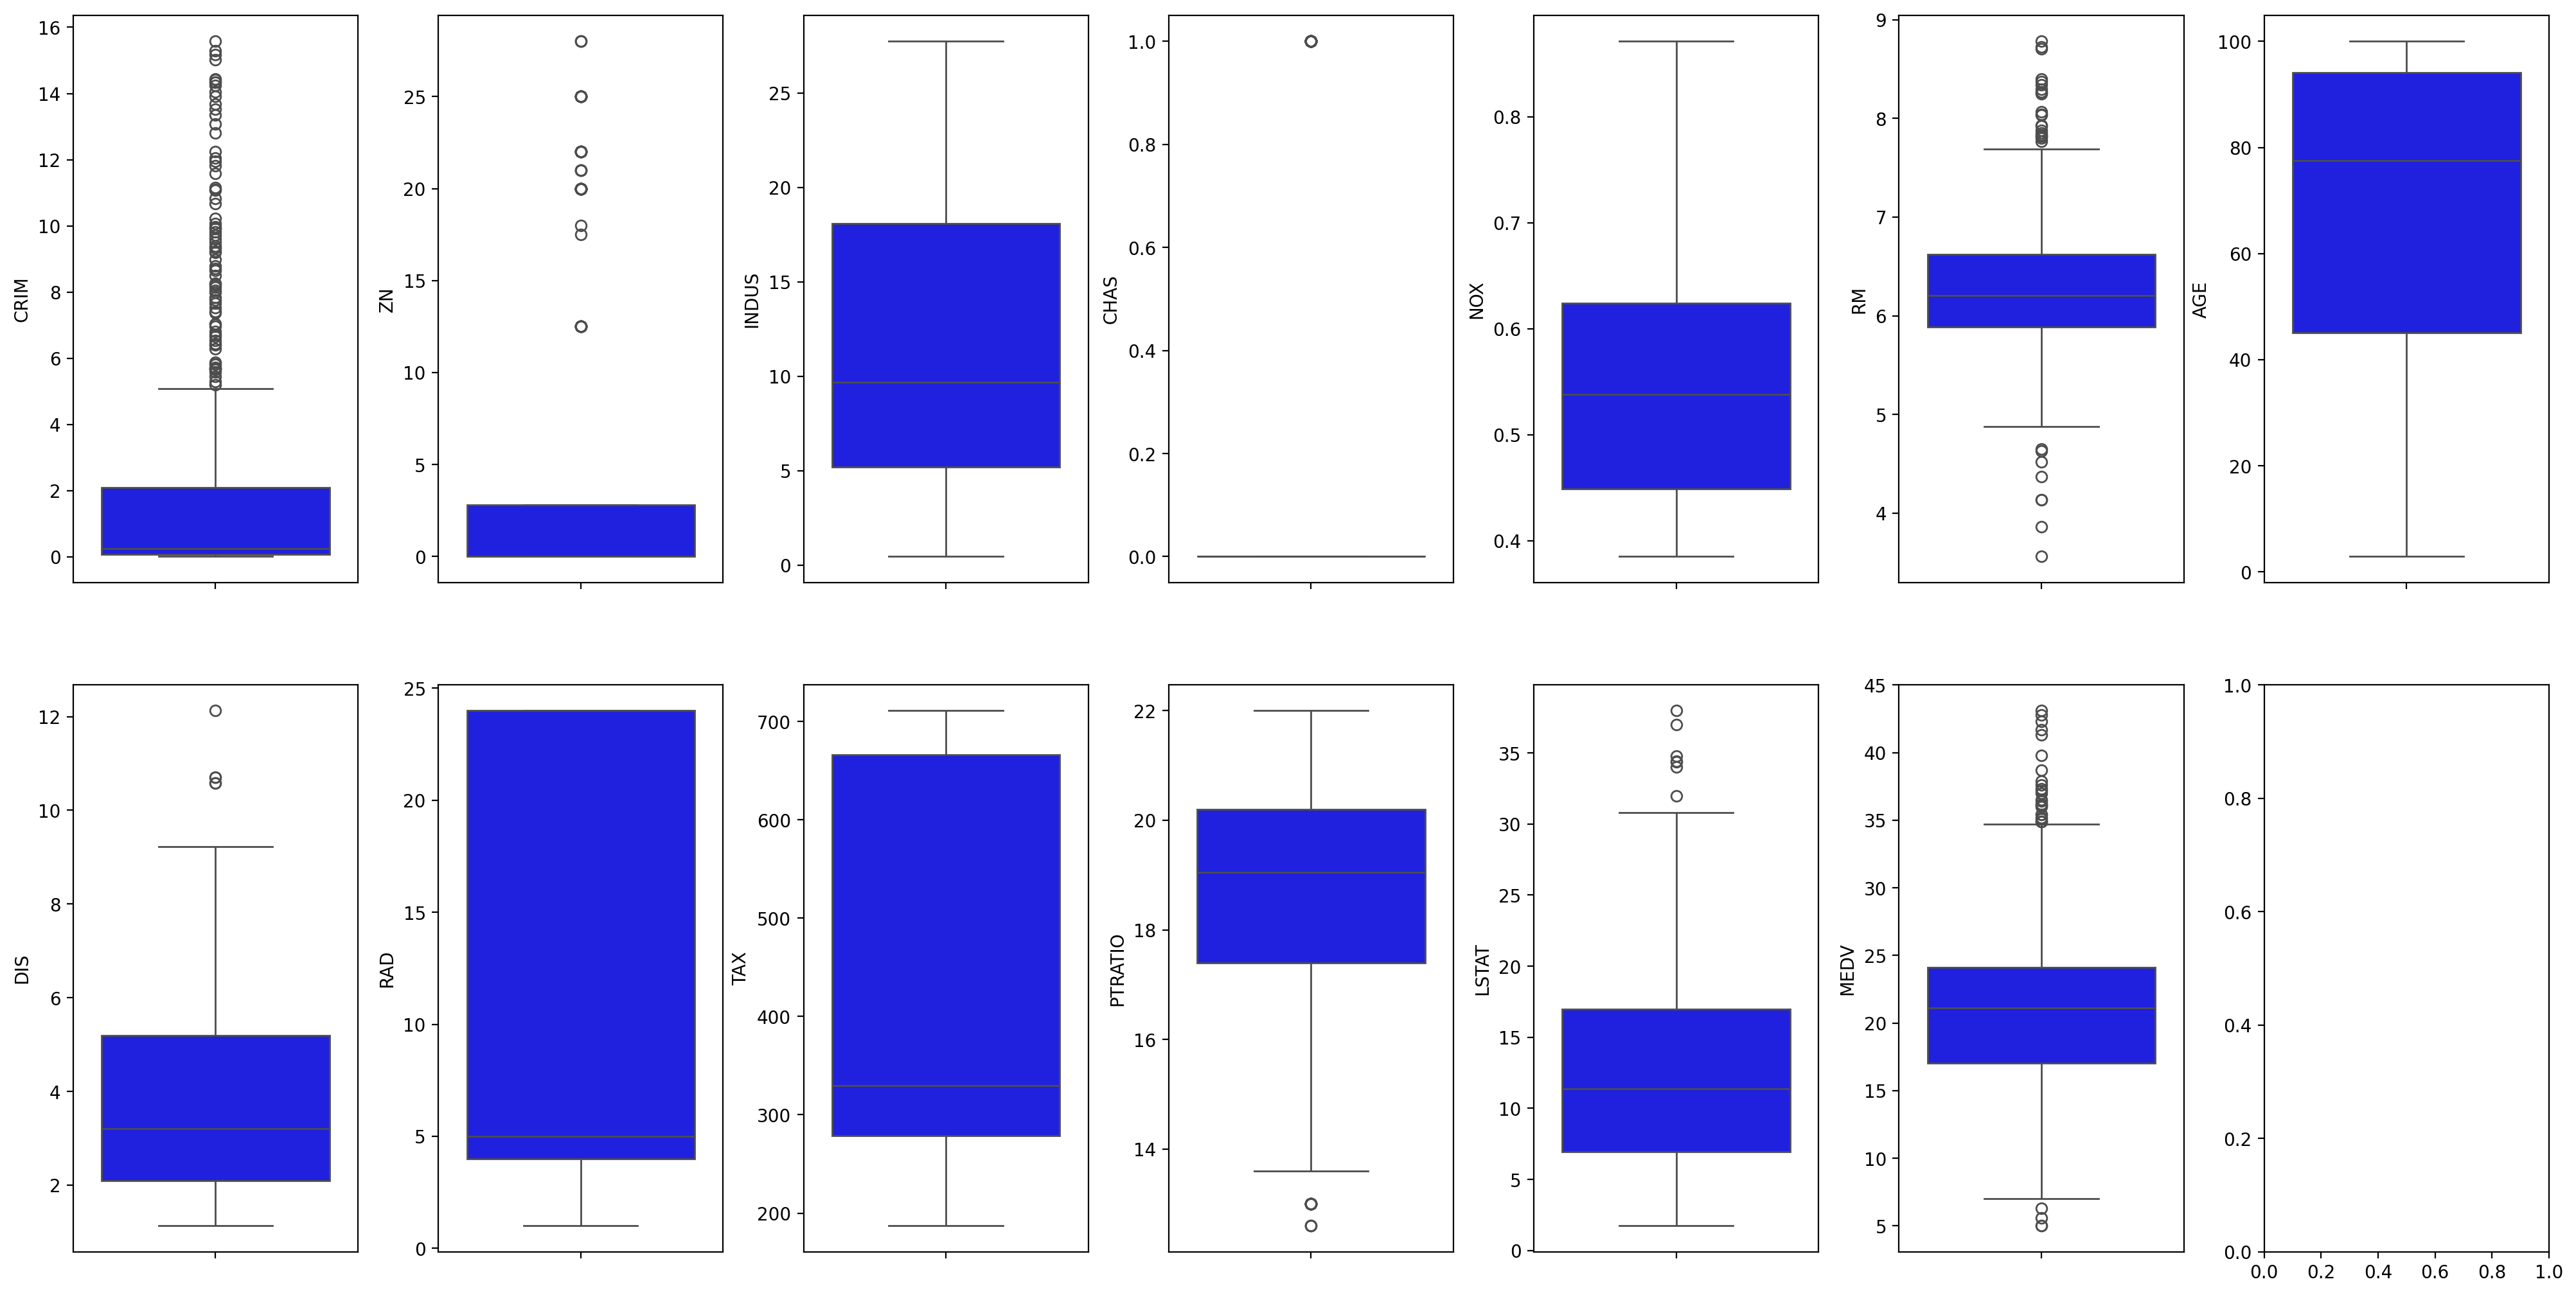

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index], color='blue')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


# Creating correlation matrix

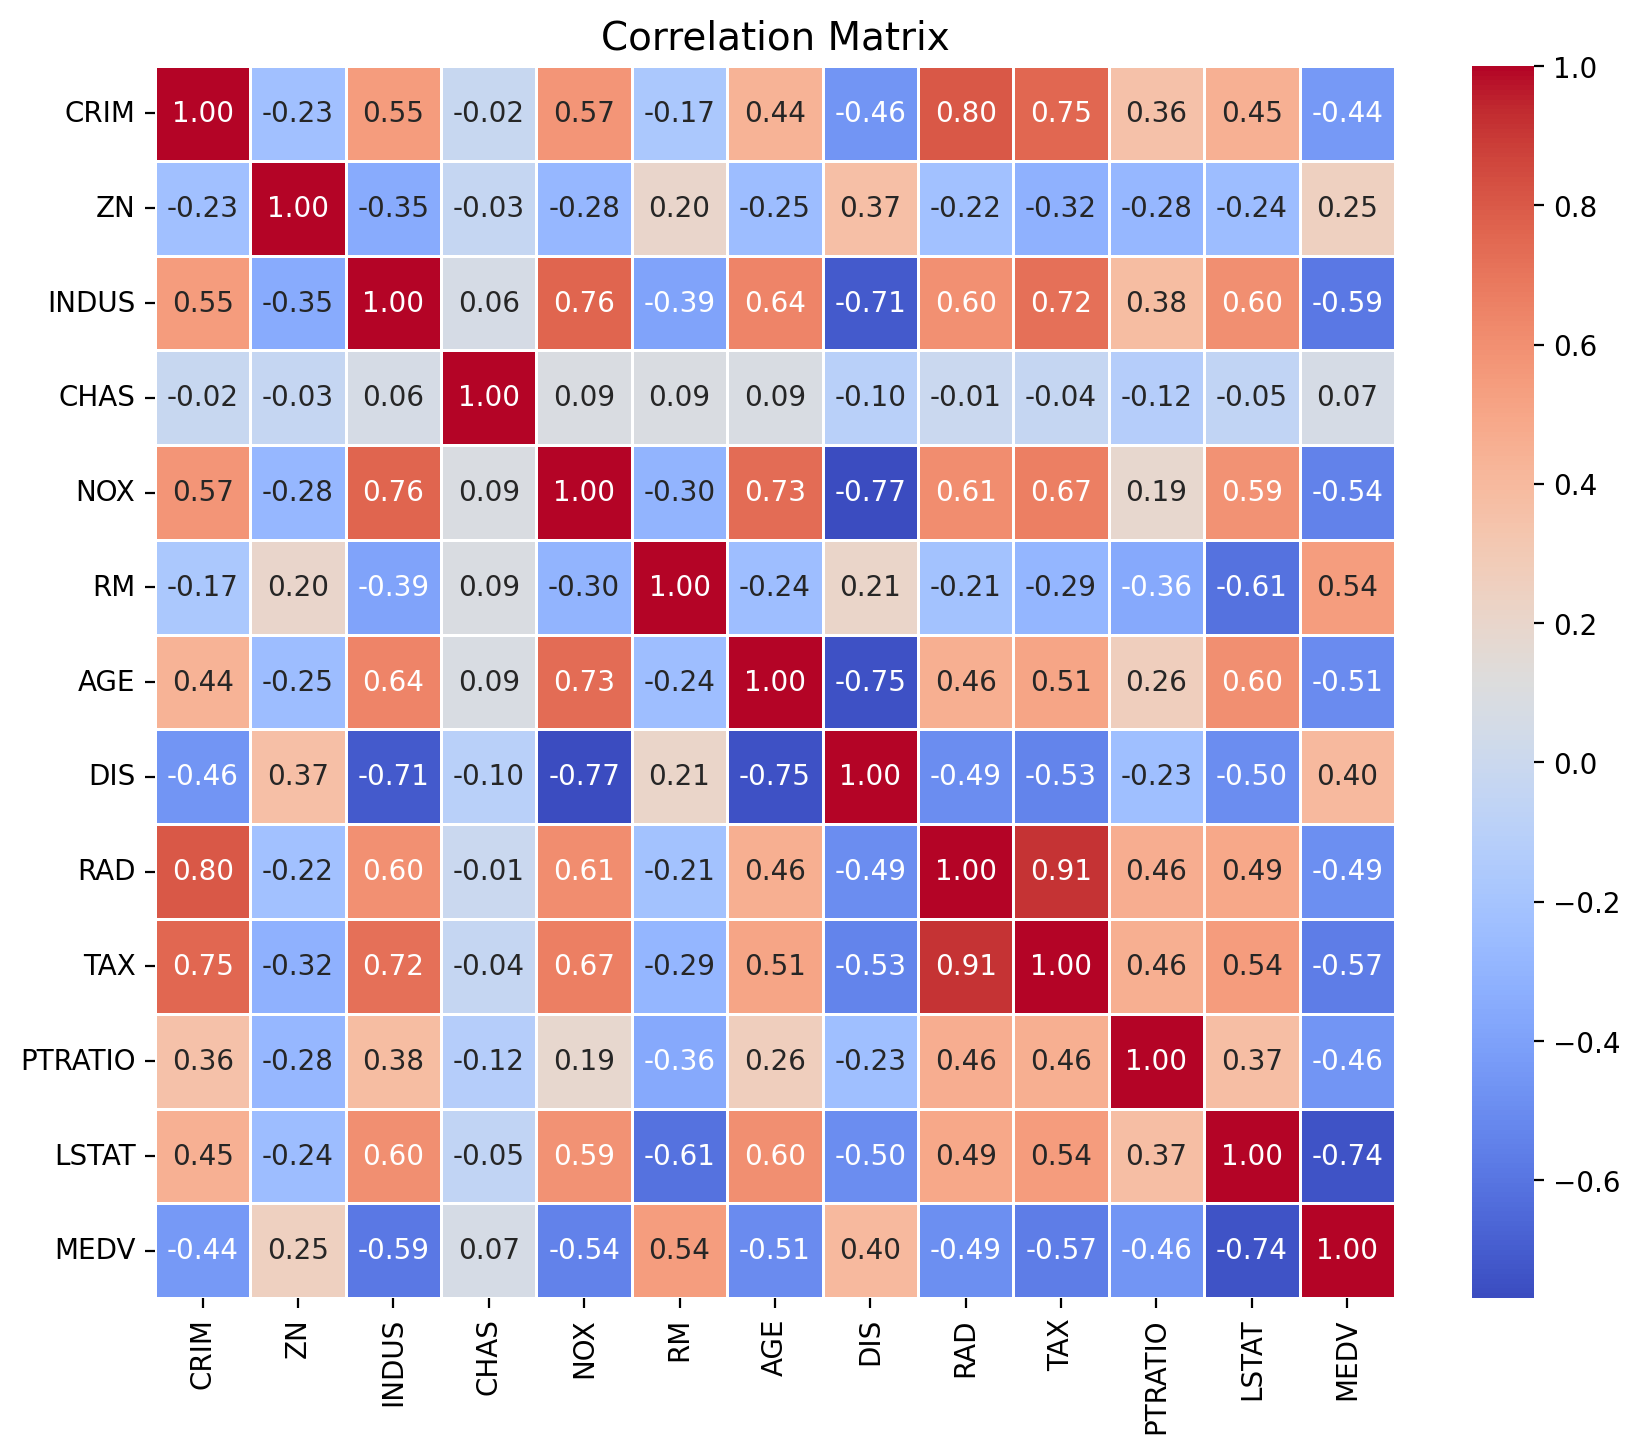

In [ ]:
# Import the seaborn library
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr()

# Display correlation matrix
# print(corr_matrix)

# Set figure size for better readability
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Set title
plt.title("Correlation Matrix", fontsize=14)

# Show the plot
plt.show()

# Print VIF, to see corellation measurement

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numerical predictor variables
X = data.drop(columns=['MEDV'])  # Assuming 'MEDV' is the response variable

# Add a constant for intercept (required for VIF calculation)
X = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)


    Feature         VIF
0     const  542.499868
1      CRIM    2.947698
2        ZN    1.301001
3     INDUS    3.944053
4      CHAS    1.073913
5       NOX    4.379832
6        RM    1.883504
7       AGE    3.064952
8       DIS    3.489870
9       RAD    8.548879
10      TAX    8.953991
11  PTRATIO    1.672637
12    LSTAT    2.784583


# Get rid of 'RAD' variable.

In [ ]:
# Delete the 'RAD' column
data = data.drop('RAD', axis=1)

# Splitting data into training set and validation set

In [ ]:
# Import the necessary function
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
np.random.seed(123)

# Define X and y
X = data.drop('MEDV', axis=1)  # Features (all columns except 'MEDV')
y = data['MEDV']  # Target variable

# Split the dataset into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=406, random_state=123)

# Check the shapes of the train and validation sets
print(x_train.shape)
print(x_valid.shape)

(406, 11)
(100, 11)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(123)

# Define X and y
X = data.drop('MEDV', axis=1)  # Features (all columns except 'MEDV')
y = data['MEDV']  # Target variable

# Split into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=406, random_state=123)

# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform K-means clustering within each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_scaled)):
    print(f"Fold {fold+1}:")

    # Split the training data into new training and validation sets
    x_train_fold, x_val_fold = x_train_scaled[train_idx], x_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Apply K-means clustering on the training fold
    kmeans = KMeans(n_clusters=2, random_state=934)
    x_train_clusters = kmeans.fit_predict(x_train_fold)

    # Assign cluster labels to training fold
    x_train_df = pd.DataFrame(x_train_fold, columns=X.columns, index=y_train_fold.index)
    x_train_df['cluster'] = x_train_clusters

    # Join with target variable
    train_data = x_train_df.join(y_train_fold, how='inner')

    # Predict clusters for the validation fold
    x_val_clusters = kmeans.predict(x_val_fold)

    x_val_df = pd.DataFrame(x_val_fold, columns=X.columns, index=y_val_fold.index)
    x_val_df['cluster'] = x_val_clusters

    # Join with target variable
    val_data = x_val_df.join(y_val_fold, how='inner')

    # Compute cluster statistics
    cluster_summary = train_data.groupby('cluster').agg({'MEDV': ['mean', 'count']})
    print(cluster_summary, "\n")


Fold 1:
              MEDV      
              mean count
cluster                 
0        16.167368   123
1        23.793831   201 

Fold 2:
              MEDV      
              mean count
cluster                 
0        24.067272   192
1        16.421701   133 

Fold 3:
              MEDV      
              mean count
cluster                 
0        24.363968   195
1        15.537365   130 

Fold 4:
              MEDV      
              mean count
cluster                 
0        24.248229   192
1        16.442002   133 

Fold 5:
              MEDV      
              mean count
cluster                 
0        15.412634   121
1        24.268922   204 



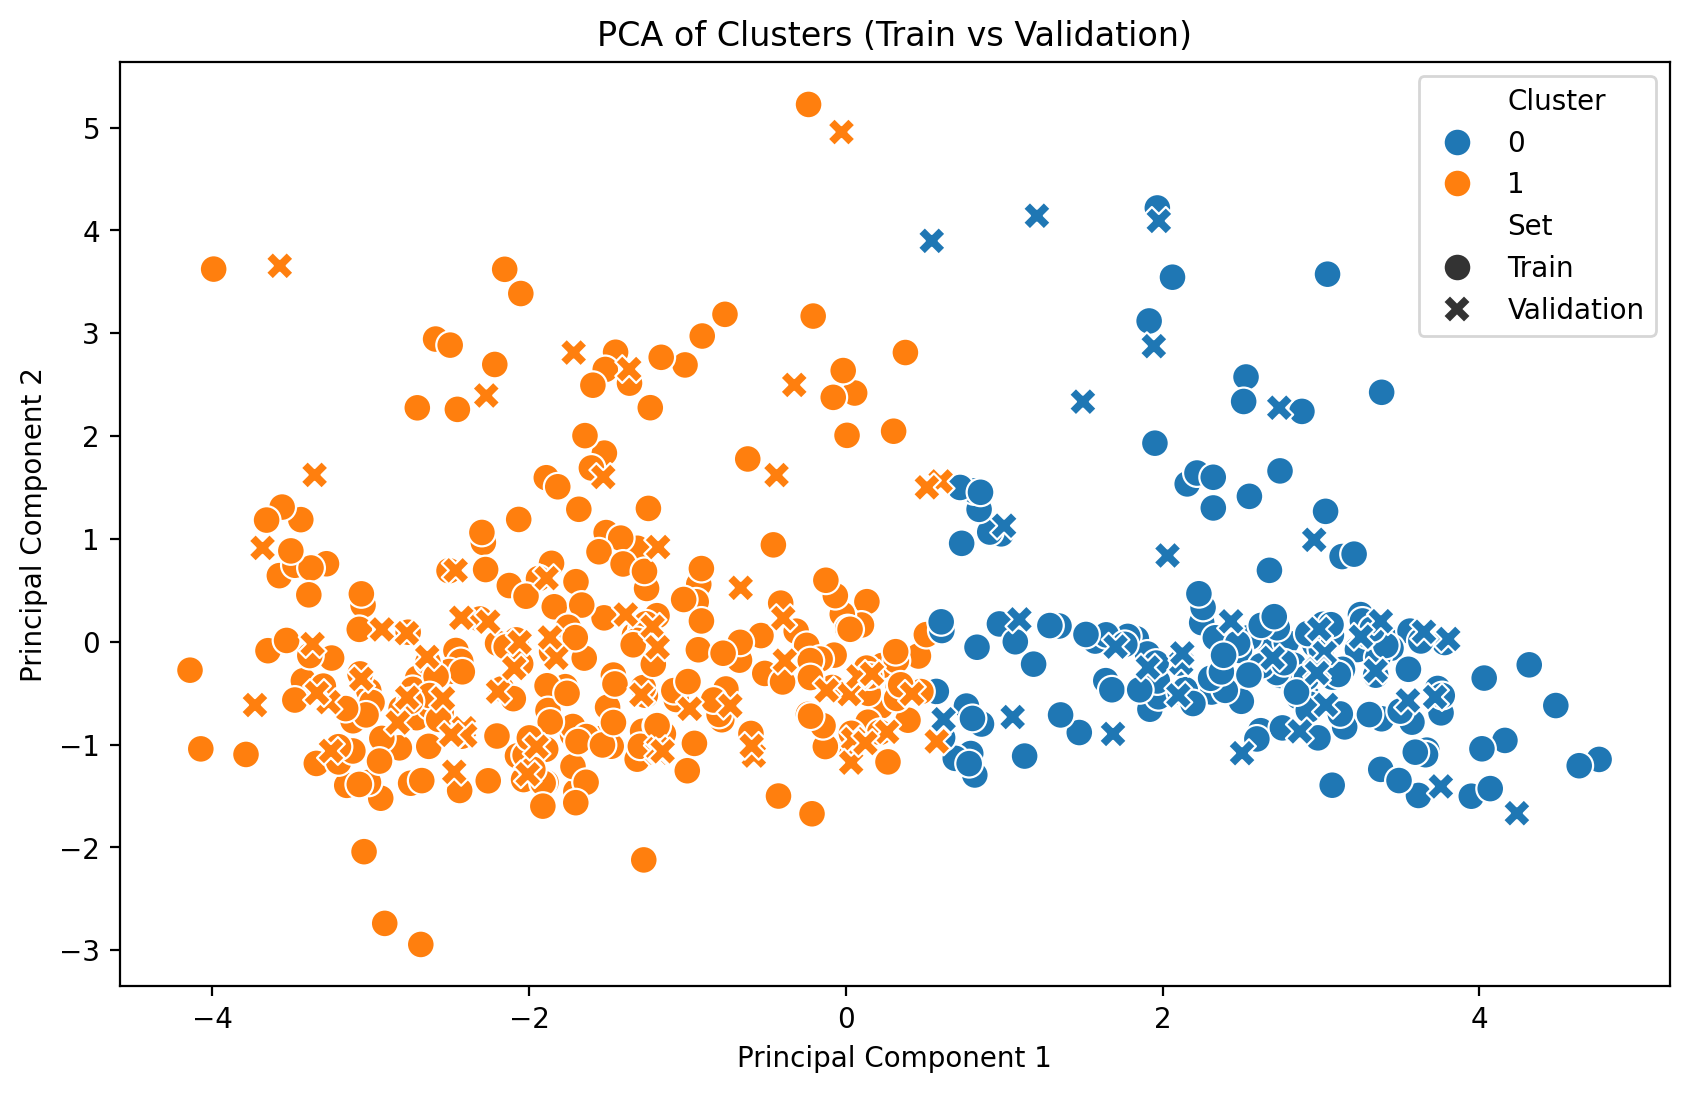

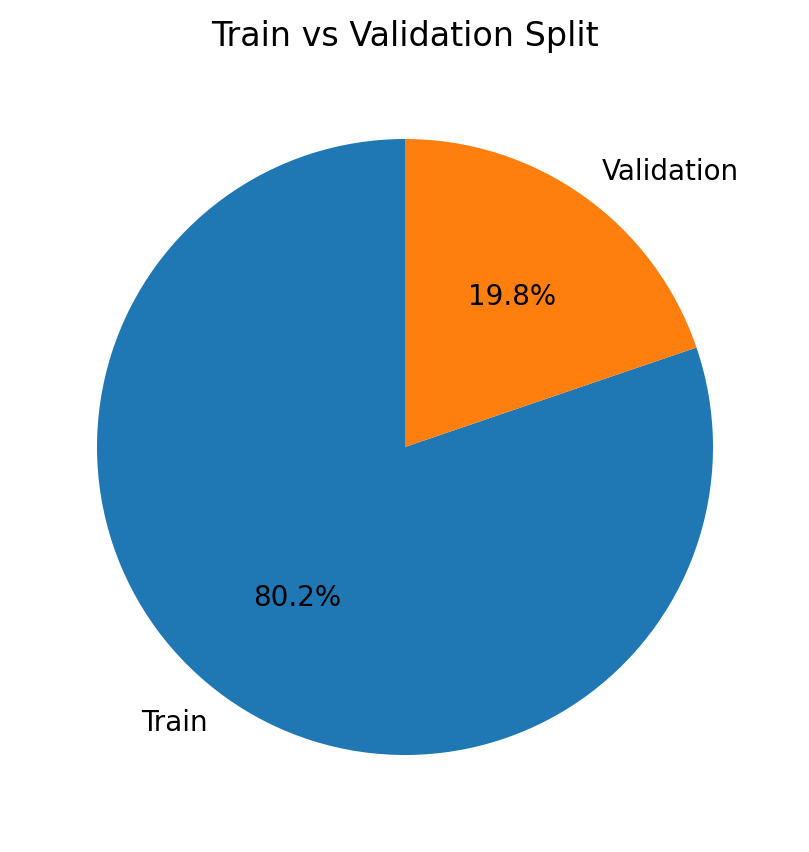

Explained Variance Ratio: [0.4783599  0.11913745]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)  # Fit and transform on training set
x_valid_pca = pca.transform(x_valid_scaled)  # Transform validation set using same PCA

# Create DataFrames for visualization
# Ensure x_train_clusters has the correct length
x_train_clusters = kmeans.fit_predict(x_train_scaled)  # Fit on the entire scaled training data

plot_data = pd.DataFrame({
    'PC1': x_train_pca[:, 0],
    'PC2': x_train_pca[:, 1],
    'Cluster': x_train_clusters,  # Use the correctly sized x_train_clusters
    'Set': 'Train'
})
valid_plot_data = pd.DataFrame({
    'PC1': x_valid_pca[:, 0],
    'PC2': x_valid_pca[:, 1],
    'Cluster': kmeans.predict(x_valid_scaled),  # Predict clusters for validation set
    'Set': 'Validation'
})

# Combine train and validation data
plot_data = pd.concat([plot_data, valid_plot_data])

# Plot clusters in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='PC1', y='PC2', hue='Cluster', style='Set', s=100)
plt.title('PCA of Clusters (Train vs Validation)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Pie chart showing the train-validation split
split_counts = pd.Series({'Train': len(x_train), 'Validation': len(x_valid)})
plt.figure(figsize=(5, 5))
plt.pie(split_counts, labels=split_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Train vs Validation Split')
plt.show()

# Print the explained variance ratio of the first two principal components
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Standardize the data
#scaler = StandardScaler()
#x_train_scaled = scaler.fit_transform(x_train)
#x_valid_scaled = scaler.transform(x_valid)

# Initialize and fit Ridge regression model
ridge = Ridge(alpha=1.0)  # You can adjust alpha (regularization strength)
ridge.fit(x_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge.predict(x_valid_scaled)

# Print coefficients

print("Ridge Coefficients:", ridge.coef_)


Ridge Coefficients: [ 0.13212419  0.20248372 -0.28116159  0.27216331 -1.18285668  0.66980654
 -0.18564429 -0.99720961 -0.82512006 -0.9132041  -3.39752146]


In [ ]:
import pandas as pd

# Create a DataFrame for better visualization
ridge_results = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": ridge.coef_
})

# Filter only selected features (nonzero coefficients)
ridge_results = ridge_results[ridge_results["Coefficient"] != 0]

# Print the table
print("Intercept:", ridge.intercept_)
print(ridge_results)

Intercept: 20.939171798029555
    Feature  Coefficient
0      CRIM     0.132124
1        ZN     0.202484
2     INDUS    -0.281162
3      CHAS     0.272163
4       NOX    -1.182857
5        RM     0.669807
6       AGE    -0.185644
7       DIS    -0.997210
8       TAX    -0.825120
9   PTRATIO    -0.913204
10    LSTAT    -3.397521


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Compute MSE for Ridge Prediction:
mse_valid_ridge = mean_squared_error(y_valid, y_pred_ridge)

# Print results
print(f"Validation MSE: {mse_valid_ridge:.4f}")

# Compute R^2 score for Ridge Regression:
r2_valid_ridge = r2_score(y_valid, y_pred_ridge)

# Print R^2
print(f"Validation R^2: {r2_valid_ridge:.4f}")


# Number of samples (n) and predictors (p)
n = len(y_valid)  # Number of observations
p = x_train.shape[1]  # Number of predictors (features)

# Compute Adjusted R^2
adjusted_r2 = 1 - (1 - r2_valid_ridge) * ((n - 1) / (n - p - 1))

# Print Adjusted R^2
print(f"Validation Adjusted R^2: {adjusted_r2:.4f}")



Validation MSE: 19.2245
Validation R^2: 0.6212
Validation Adjusted R^2: 0.5738


In [ ]:
# Compute RSS (Residual Sum of Squares)
# Predictions on the training set (scaled)
y_pred_ridge1 = ridge.predict(x_train_scaled)
rss1 = np.sum((y_train - y_pred_ridge1) ** 2)
print('RSS is ', rss1)

# Compute Log-Likelihood (assuming Gaussian errors)
n1 = len(y_train)
sigma_squared1 = rss1 / n1
log_likelihood1 = -0.5 * n1 * np.log(2 * np.pi * sigma_squared1) - (rss1 / (2 * sigma_squared1))

# Count nonzero coefficients (number of selected features)
k1 = np.sum(ridge.coef_ != 0)

# Compute AIC and BIC
AIC_r = 2 * k1 - 2 * log_likelihood1
BIC_r = k1 * np.log(n1) - 2 * log_likelihood1


print("AIC:", AIC_r)
print("BIC:", BIC_r)


RSS is  7090.870349802195
AIC: 2335.4234341277047
BIC: 2379.493318883324


In [ ]:
from sklearn.linear_model import Lasso

# Initialize and fit Lasso regression model
lasso = Lasso(alpha=0.1)  # Adjust alpha to control sparsity
lasso.fit(x_train_scaled, y_train)

# Predictions
y_pred_lasso = lasso.predict(x_valid_scaled)

# Print selected features (nonzero coefficients)
selected_features = x_train.columns[lasso.coef_ != 0]
# print("Selected Features:", selected_features)
# print("Lasso Coefficients:", lasso.coef_)


In [ ]:
import pandas as pd

# Create a DataFrame for better visualization
lasso_results = pd.DataFrame({
    "Feature": x_train.columns,
    "Coefficient": lasso.coef_
})

# Filter only selected features (nonzero coefficients)
lasso_results = lasso_results[lasso_results["Coefficient"] != 0]

print("Intercept:", lasso.intercept_)
# Print the table
print(lasso_results)


Intercept: 20.939171798029555
    Feature  Coefficient
1        ZN     0.048826
2     INDUS    -0.152843
3      CHAS     0.164212
4       NOX    -0.829846
5        RM     0.698550
7       DIS    -0.397617
8       TAX    -0.812652
9   PTRATIO    -0.850570
10    LSTAT    -3.398084


In [ ]:
# Compute RSS (Residual Sum of Squares)
# Predictions on the training set (scaled)
y_pred_lasso1 = lasso.predict(x_train_scaled)
rss = np.sum((y_train - y_pred_lasso1) ** 2)

# Compute Log-Likelihood (assuming Gaussian errors)
n = len(y_train)
sigma_squared = rss / n
log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma_squared) - (rss / (2 * sigma_squared))

# Count nonzero coefficients (number of selected features)
k = np.sum(lasso.coef_ != 0)

# Compute AIC and BIC
AIC = 2 * k - 2 * log_likelihood
BIC = k * np.log(n) - 2 * log_likelihood

# Print Results
print("Selected Features:", X.columns[lasso.coef_ != 0].tolist())
print("Lasso Coefficients:", lasso.coef_)
print("AIC:", AIC)
print("BIC:", BIC)



Selected Features: ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']
Lasso Coefficients: [-0.          0.04882631 -0.15284262  0.16421166 -0.82984619  0.69854976
 -0.         -0.39761671 -0.81265186 -0.8505696  -3.39808397]
AIC: 2334.9512089726786
BIC: 2371.008387409094


**NOTE**

**Lower AIC and lower BIC, mean model performing better**

In [ ]:
from sklearn.metrics import mean_squared_error

# Compute MSE for Lasso Prediction:
mse_valid_lasso = mean_squared_error(y_valid, y_pred_lasso)

# Print results
print(f"Validation MSE: {mse_valid_lasso:.4f}")
# -------------------------------------------------------
# Compute R^2 score for Lasso Regression:
r2_valid_lasso = r2_score(y_valid, y_pred_lasso)

# Print R^2
print(f"Validation R^2: {r2_valid_lasso:.4f}")

# -------------------------------------------------------
# Number of samples (n) and predictors (p)
n = len(y_valid)  # Number of observations
p = x_train.shape[1]  # Number of predictors (features)

# Compute Adjusted R^2
adjusted_r2_lasso = 1 - (1 - r2_valid_lasso) * ((n - 1) / (n - p - 1))

# Print Adjusted R^2
print(f"Validation Adjusted R^2: {adjusted_r2_lasso:.4f}")



Validation MSE: 19.6317
Validation R^2: 0.6131
Validation Adjusted R^2: 0.5648


**Prior Distribution**



<ipython-input-25-f6584364f052>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "0.5" (-> color=(0.5, 0.5, 0.5, 1.0)). The keyword argument will take precedence.
  plot(x, y_avg, '0.5', lw=0.5, color = 'blue')


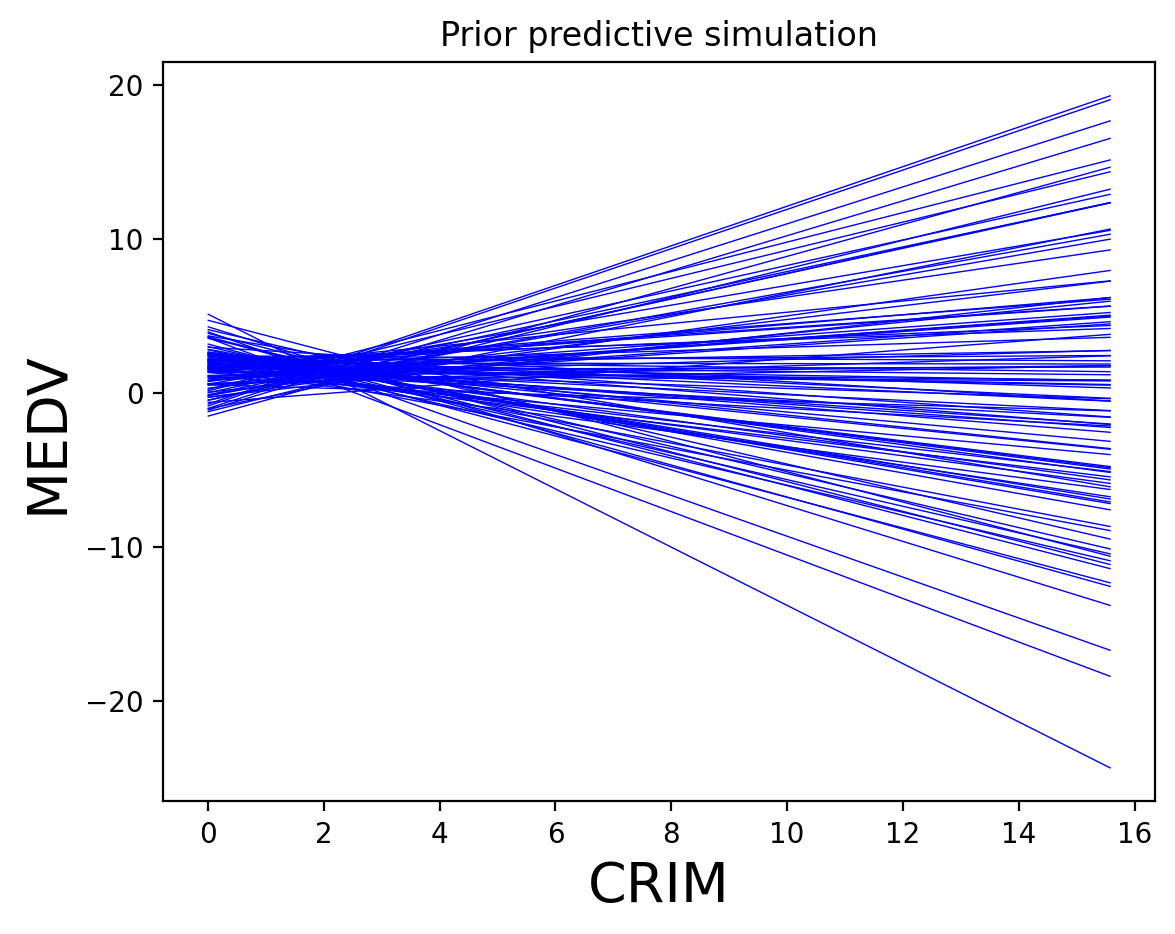

In [ ]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(1.5, 0.5, n_samples)
beta1 = stats.norm.rvs(0, 0.5, n_samples)

xmin = (x_train['CRIM'].min())
xmax = (x_train['CRIM'].max())
xmean = (x_train['CRIM'].mean())
x = linspace(xmin, xmax, 5) ## Crime range

y_avg = alpha[None, :] + beta1[None, :]*(x[:, None] - xmean) ## we are using broadcasting here

plot(x, y_avg, '0.5', lw=0.5, color = 'blue')
#ylim(-5, 300)
title('Prior predictive simulation')
xlabel('CRIM', fontsize=20)
ylabel('MEDV', fontsize=20);

#**MCMC**

Using MCMC to predict the MEDV.

In [ ]:
with pm.Model() as model1:
    sigma = pm.Exponential('sigma', 1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1.5)
    beta2 = pm.Normal('beta2', mu=0, sigma=1.5)
    beta3 = pm.Normal('beta3', mu=0, sigma=1.5)
    beta4 = pm.Normal('beta4', mu=0, sigma=1.5)
    beta5 = pm.Normal('beta5', mu=0, sigma=1.5)
    beta6 = pm.Normal('beta6', mu=0, sigma=1.5)
    beta7 = pm.Normal('beta7', mu=-0.05, sigma=1.5)
    beta8 = pm.Normal('beta8', mu=0, sigma=1.5)
    beta10 = pm.Normal('beta10', mu=0, sigma=1.5)
    beta11 = pm.Normal('beta11', mu=0, sigma=1.5)
    beta12 = pm.Normal('beta12', mu=0, sigma=1.5)

    alpha = pm.Normal('alpha', mu=20, sigma=3)



    _mu = (alpha + beta1*x_train['CRIM'] + beta2*x_train['ZN']+beta3*x_train['INDUS']+beta4*x_train['CHAS']+beta5*x_train['NOX']+beta6*x_train['RM']+beta7*x_train['AGE']+beta8*x_train['DIS']+beta10*x_train['TAX']+beta11*x_train['PTRATIO']+beta12*x_train['LSTAT'])
   # _mu = (alpha + beta1*x_train_scaled['CRIM'] + beta2*x_train_scaled['ZN']+beta3*x_train_scaled['INDUS']+beta4*x_train_scaled['CHAS']+beta5*x_train_scaled['NOX']+beta6*x_train_scaled['RM']+beta7*x_train_scaled['AGE']+beta8*x_train_scaled['DIS']+beta10*x_train_scaled['TAX']+beta11*x_train_scaled['PTRATIO']+beta12*x_train_scaled['LSTAT'])
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later

    # Likelihood function
    y_new = pm.Normal('MEDV', mu=mu, sigma=sigma, observed=y_train)
    # (draws=1000, tune=1000, chains=2, return_inferencedata=True)
    _model1_samples = pm.sample(500, tune=500, chains=2, return_inferencedata=True)
model1_mcmc_samples = _model1_samples.posterior.to_dataframe()

Output()

In [ ]:
varnames = ['beta1', 'beta2', 'beta3', 'beta4','beta5', 'beta6', 'beta7', 'beta8', 'beta10','beta11', 'beta12', 'sigma', 'alpha']
display(pm.summary(_model1_samples))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    24.797  2.443  19.969   28.884      0.074    0.052    1098.0   
beta1    -0.032  0.094  -0.207    0.142      0.003    0.002    1066.0   
beta10   -0.006  0.002  -0.011   -0.002      0.000    0.000     915.0   
beta11   -0.186  0.103  -0.389    0.007      0.003    0.002    1110.0   
beta12   -0.458  0.046  -0.536   -0.362      0.002    0.001     785.0   
...         ...    ...     ...      ...        ...      ...       ...   
mu[402]  16.009  0.433  15.162   16.813      0.014    0.010     907.0   
mu[403]  23.644  0.410  22.812   24.367      0.012    0.008    1185.0   
mu[404]  12.069  0.513  11.090   13.014      0.015    0.010    1197.0   
mu[405]  16.593  1.151  14.550   18.803      0.039    0.028     870.0   
sigma     4.272  0.142   3.993    4.517      0.004    0.003    1521.0   

         ess_tail  r_hat  
alpha       514.0    1.0  
beta1       857.0    1.0  
beta10      590.0    1.0  
beta11      878.0    1.0  
beta12      670.0    1.0  
...           ...    ...  
mu[402]     845.0    1.0  
mu[403]     900.0    1.0  
mu[404]     870.0    1.0  
mu[405]     682.0    1.0  
sigma       692.0    1.0  

[419 rows x 9 columns]

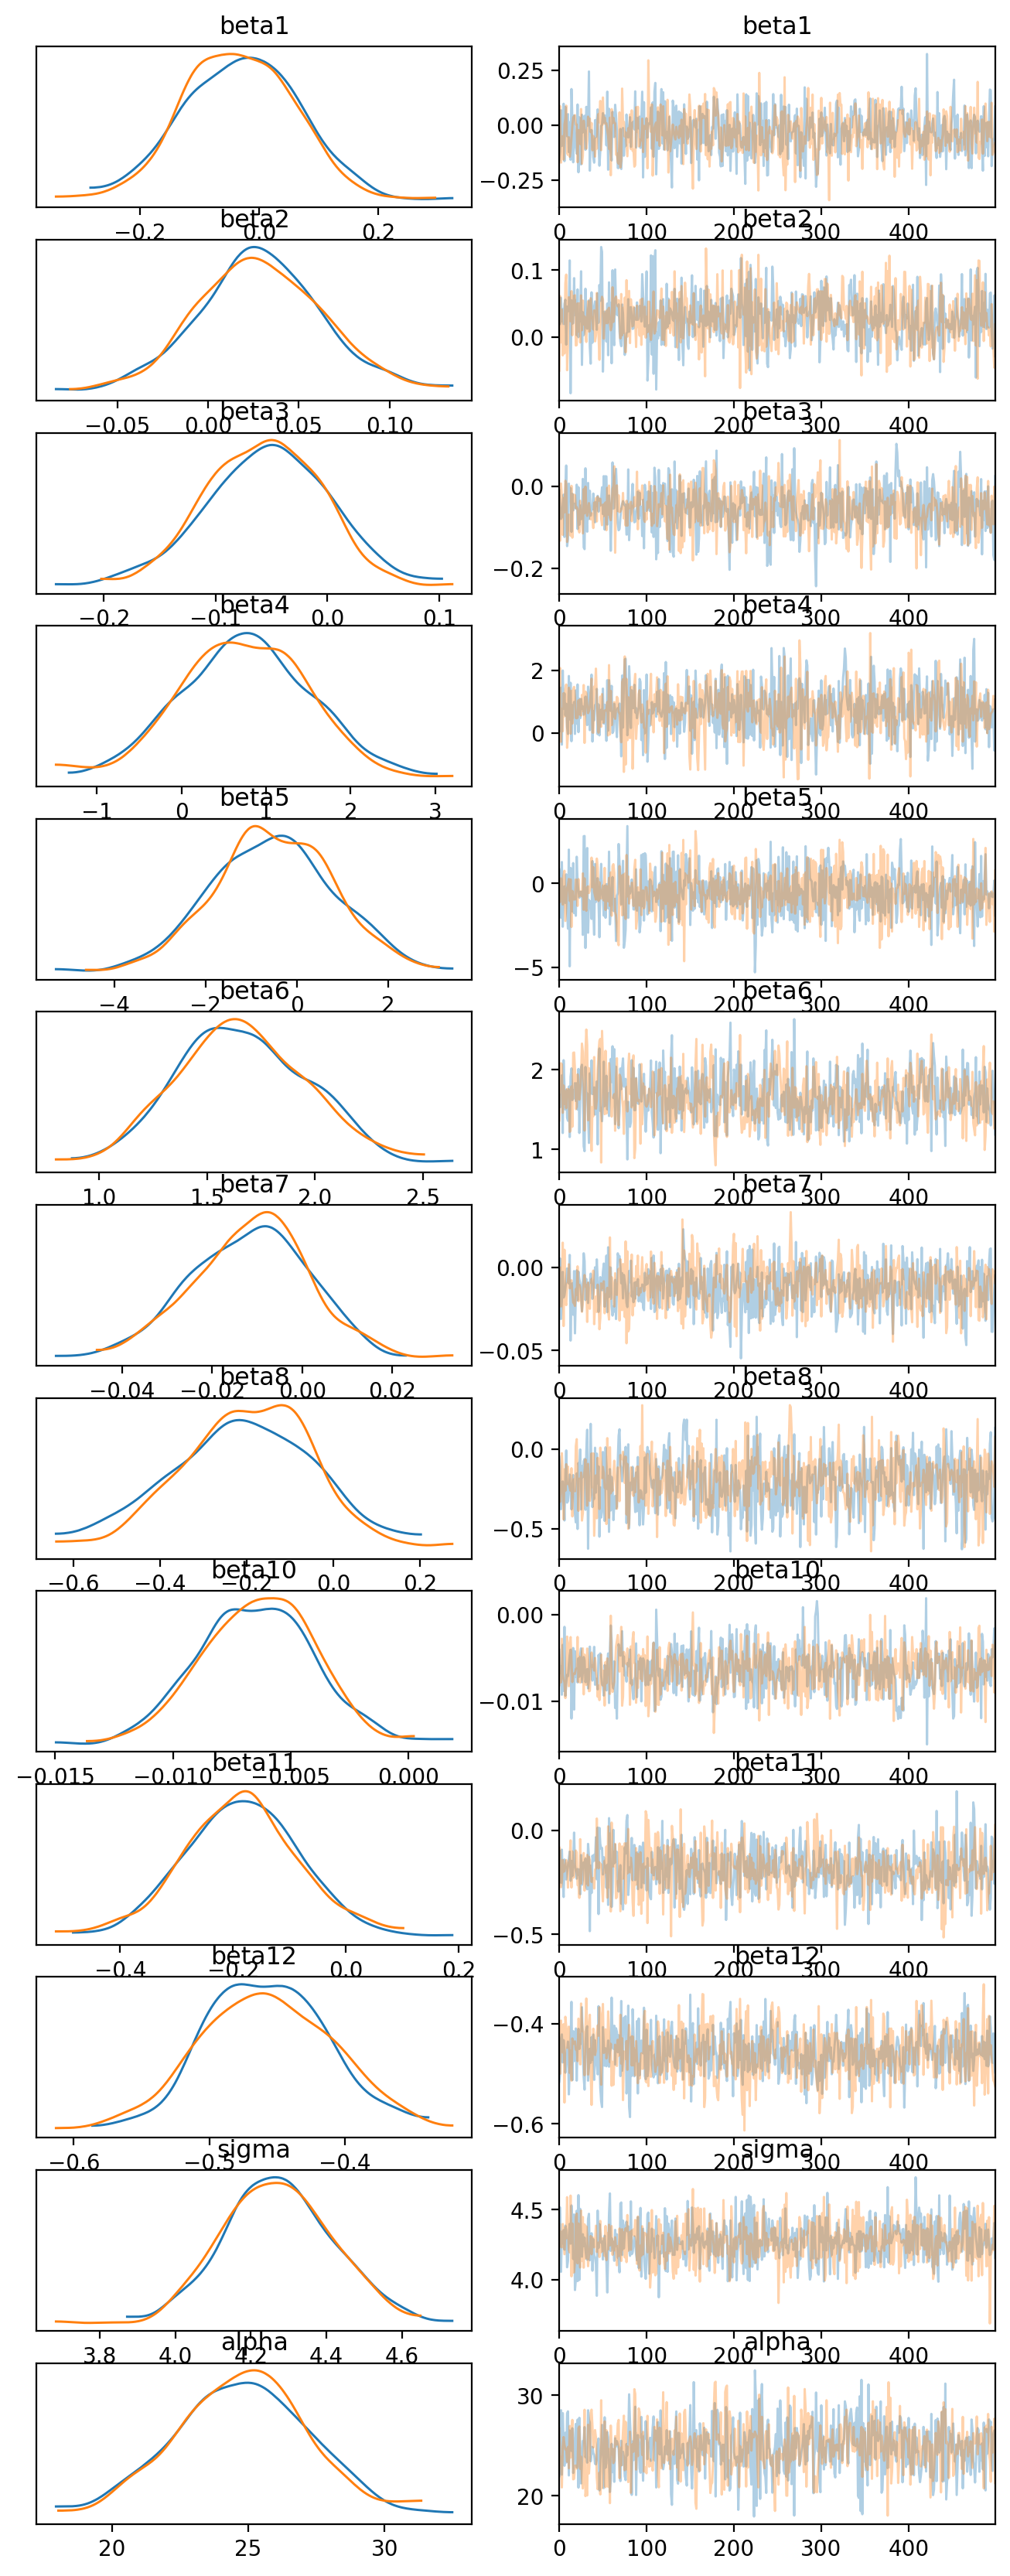

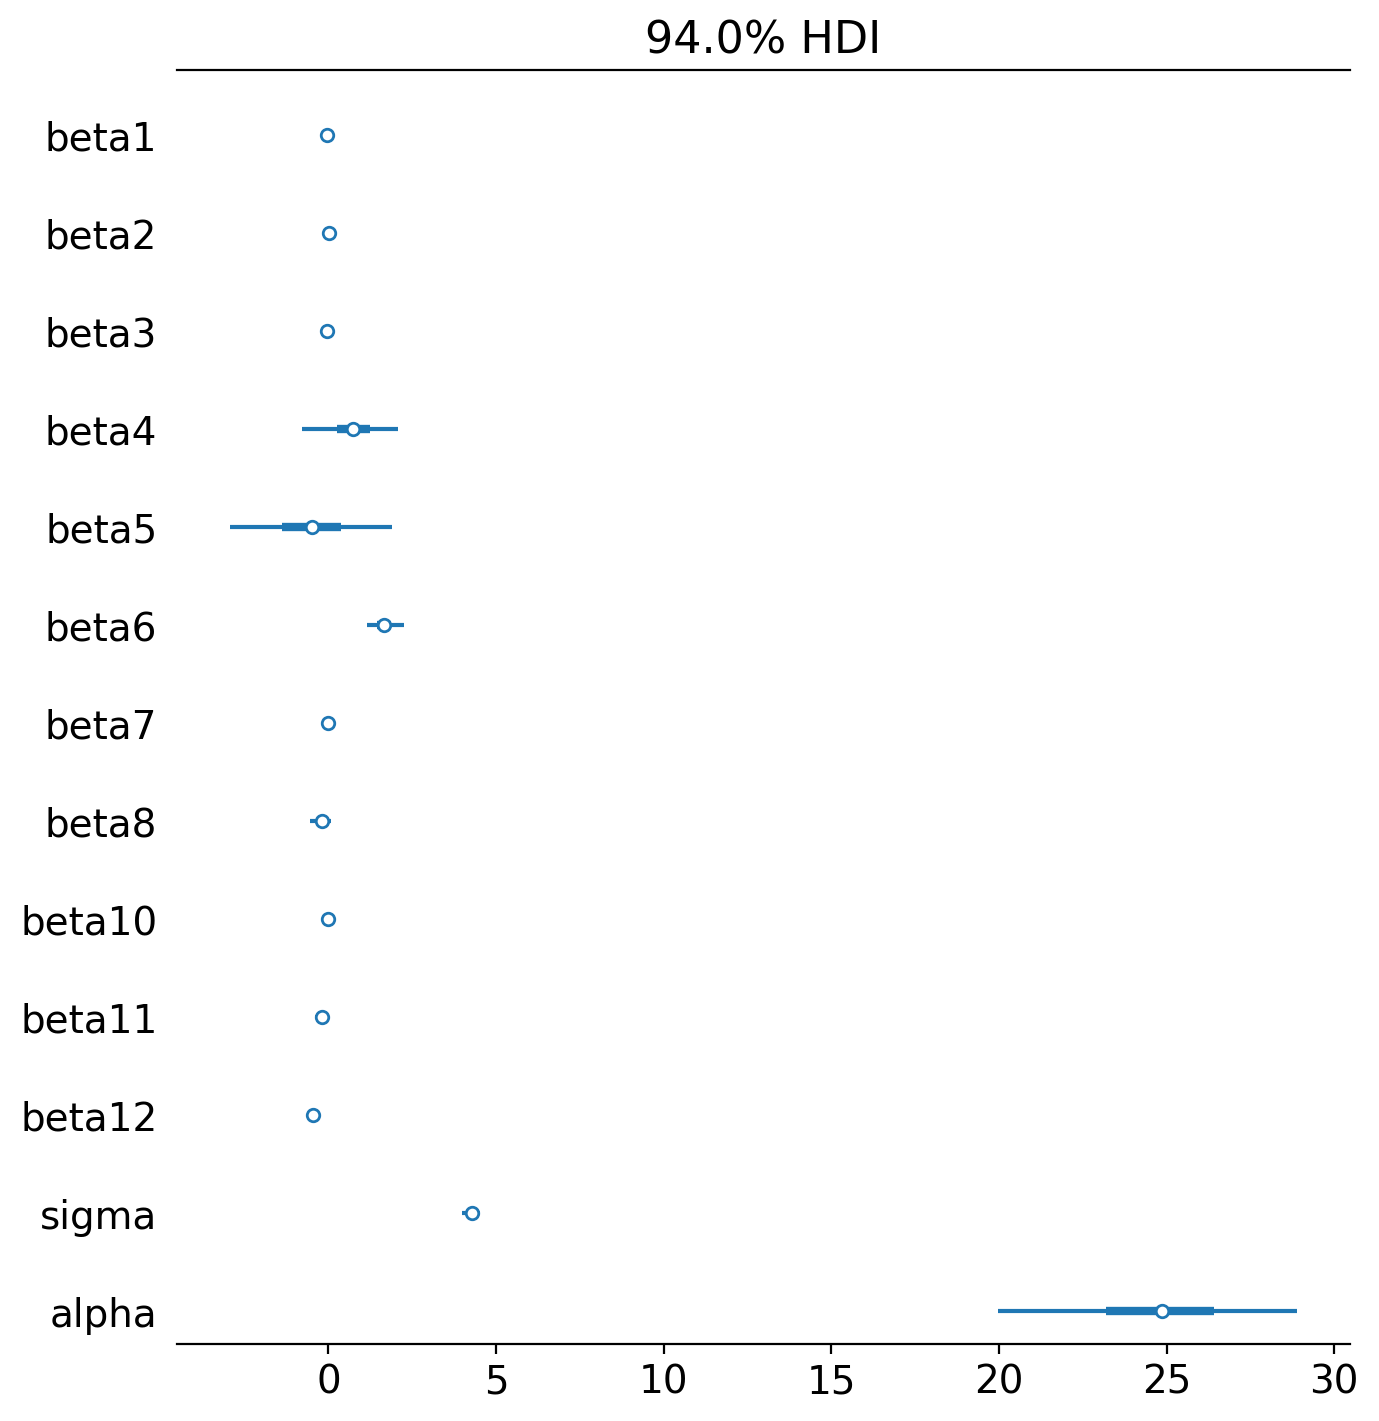

In [ ]:
# Set figure size for better readability
figsize = (7, 2 + 0.4 * len(varnames))  # Dynamic height based on variable count

# Trace plot (optional, if needed)
az.plot_trace(_model1_samples, var_names=varnames, compact=False, figsize=(8, 1.6 * len(varnames)))

# Improved Forest Plot
az.plot_forest(
    _model1_samples,
    var_names=varnames,
    combined=True,
    figsize=figsize,
    hdi_prob=0.94,  # Explicitly setting HDI
    ridgeplot_alpha=0.7,  # Slight transparency for better visualization
    markersize=6  # Larger points
)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [ ]:
#import pymc as pm
#import numpy as np

# Assume '_model1_samples' is your posterior trace
posterior_samples = az.extract(_model1_samples)  # Extract samples

# Get posterior means for coefficients
# Instead of 'beta', access individual betas:
beta1_samples = posterior_samples["beta1"]
beta2_samples = posterior_samples["beta2"]
beta3_samples = posterior_samples["beta3"]
beta4_samples = posterior_samples["beta4"]
beta5_samples = posterior_samples["beta5"]
beta6_samples = posterior_samples["beta6"]
beta7_samples = posterior_samples["beta7"]
beta8_samples = posterior_samples["beta8"]
# beta9_samples = posterior_samples["beta9"]
beta10_samples = posterior_samples["beta10"]
beta11_samples = posterior_samples["beta11"]
beta12_samples = posterior_samples["beta12"]
alpha_samples = posterior_samples["alpha"]  # Intercept

# Stack beta samples into a single array:
beta_samples = np.stack([beta1_samples, beta2_samples, beta3_samples, beta4_samples,
                         beta5_samples, beta6_samples, beta7_samples, beta8_samples,
                        beta10_samples, beta11_samples, beta12_samples], axis=-1)

# Predictive function: y = alpha + X * beta
# Convert alpha_samples to a NumPy array and reshape
alpha_samples_np = alpha_samples.values.reshape(-1, 1)

# Reshape x_valid to match expected shape
x_valid_np = x_valid.values

# Calculate predictions for each sample
y_pred_samples = alpha_samples_np + np.dot(beta_samples, x_valid_np.T)

# Compute mean and 94% credible interval
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.94)

# Print results
print("Predicted mean:", y_pred_mean)
#print("94% HDI:", y_pred_hdi)

Predicted mean: [18.92707654 25.79913064 30.41038051 16.62205613 26.64908329 26.90166989
 25.95420027 11.25912521 15.84824401 26.322579   24.73274531 22.20823533
 17.11055161 25.25184469 18.37177442 21.3401437  20.55588647 28.43267061
 19.2824822  14.36166858 16.55123976 20.3709365  27.93418081 31.26907981
 24.04731385 19.62100341 16.69774836 23.2102118  24.06802709 21.97246325
 24.09115431 28.08263469 17.76202945 21.9638275  22.77898157 26.22938312
 25.84383473 15.69607885 17.39434107 29.28998579 26.7620161  19.46803052
 17.42969885 29.34346598 11.95265569 24.91195111 22.45341633 23.796333
 18.60204794 20.00140156 28.56819487 22.63260281 22.63704322 11.65102148
 20.69576735 16.08261333 12.16286396  7.26561069 27.67434745 13.09981688
 19.82660666 22.87834139 20.64752723 17.28639125 22.01673371 24.43401448
 25.6460431  19.15755225 24.87131556 26.48964295 20.05262724 25.73735991
 19.08760852 25.60466484 17.33748178 16.59130877 14.03117935 19.31792862
 25.93373594  3.50034541 26.42602958 

<ipython-input-47-2ec8513470c3>:40: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.94)


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the mean of the posterior predictive samples
y_pred_mean = y_pred_samples.mean(axis=0)  # Average across posterior samples

# Compute MSE using the mean prediction
mse_valid_mcmc = mean_squared_error(y_valid, y_pred_mean)

# Print results
print(f"Validation MSE: {mse_valid_mcmc:.4f}")

Validation MSE: 20.1310


In [ ]:
import numpy as np
import scipy.stats as stats

# Define standard deviation (sigma) - this should be from your model
sigma = np.std(y_valid - y_pred_lasso)  # Estimate if unknown

# Compute log-likelihood for each data point
log_likelihood_manual = stats.norm.logpdf(y_valid, loc=y_pred_lasso, scale=sigma)

# Sum log-likelihood across all data points
total_log_likelihood = np.sum(log_likelihood_manual)

print(f"Log-Likelihood: {total_log_likelihood:.4f}")


Log-Likelihood: -290.7524


In [ ]:
# Number of estimated parameters (excluding auxiliary parameters like sigma)
k = x_train.shape[1]  # Number of predictors

# Number of observations
n = len(y_train)

# Compute AIC and BIC using manually computed log-likelihood
AIC = 2 * k - 2 * total_log_likelihood
BIC = k * np.log(n) - 2 * total_log_likelihood

# Print results
print("AIC:", AIC)
print("BIC:", BIC)

AIC: 603.5048789834391
BIC: 647.5747637390582


In [ ]:
# - Calculating y_pred_mean for tran data

# Extract posterior samples from the model
posterior_samples = az.extract(_model1_samples)  # Extract samples

# Get posterior means for coefficients
# Updated list comprehension to include all 12 beta coefficients:
beta_samples = np.stack([posterior_samples[f"beta{i}"] for i in [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]], axis=-1)  # Stack all betas
alpha_samples = posterior_samples["alpha"]  # Intercept

# Convert alpha_samples to a NumPy array and reshape
alpha_samples_np = alpha_samples.values.reshape(-1, 1)

# Reshape x_train to match expected shape
x_train_np = x_train.values  # Convert to numpy array, if not already

# Calculate predictions for each sample
y_pred_samples = alpha_samples_np + np.dot(beta_samples, x_train_np.T)  # Predictions for training data

# Compute mean and 94% credible interval
y_pred_mean = y_pred_samples.mean(axis=0)  # Mean predictions
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.94)  # 94% HDI (Highest Density Interval)

# Print results
# print("Predicted mean for y_train:", y_pred_mean)
# print("94% HDI:", y_pred_hdi)

<ipython-input-51-9104b62b9d76>:22: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.94)  # 94% HDI (Highest Density Interval)


In [ ]:
import numpy as np

# Compute Total Sum of Squares (TSS)
y_mean = np.mean(y_train)
tss = np.sum((y_train - y_mean) ** 2)

# Compute Residual Sum of Squares (RSS)
rss = np.sum((y_train - y_pred_mean) ** 2)

# Compute Bayesian R²
r2_bayesian = 1 - (rss / tss)

# Calculate number of observations (n) and number of predictors (k)
n = len(y_train)  # Number of data points in the training set
k = x_train.shape[1]  # Number of predictors (features)

# Calculate Adjusted R²
r2_adj = 1 - ((1 - r2_bayesian) * (n - 1) / (n - k - 1))

# Print results
print(f"Bayesian R²: {r2_bayesian:.4f}")
print(f"Adjusted R²: {r2_adj:.4f}")


Bayesian R²: 0.6173
Adjusted R²: 0.6066


# Result without mean imputation
\begin{array}{|c|c|c|c|}
\hline
 & \textbf{Ridge Regression} & \textbf{Lasso Regression} & \textbf{MCMC Method} \\
\hline
MSE & 29.9857 & 31.1887 & 32.7134 \\
R^{2} & 0.6426 & 0.6282 & 0.7447 \\
\text{Adjusted } R^{2} & 0.5770 & 0.5891 & 0.7369 \\
AIC & 2406.32 & 2415.25 & 651.79 \\
BIC & 2458.40 & 2455.32 & 699.87 \\
\hline
\end{array}


# Coefficients without mean imputation
\begin{array}{|c|c|c|c|}
\hline
\textbf{Feature} & \textbf{Ridge Regression} & \textbf{Lasso Regression} & \textbf{MCMC Method} \\
\hline
Intercept & 22.3547 & 22.3457 & 22.42 \\
CRIM & -0.8899 & -0.6233 & -0.1 \\
ZN & 1.0679 & 0.7331 & 0.052 \\
INDUS & 0.4051 &  & 0.013 \\
CHAS & 0.3428 & 0.3029 & 0.77 \\
NOX & -1.8650 & -1.2895 & -2.577 \\
RM & 2.9599 & 3.0999 & 4.582 \\
AGE & 0.0530 &  & -0.008 \\
DIS & -2.9104 & -2.3629 & -1.17 \\
RAD & 2.2173 & 0.8696 & 0.215 \\
TAX & -2.0831 & -0.8721 & -0.013 \\
PTRATIO & -1.9107 & -1.7543 & -0.645 \\
LSTAT & -4.0477 & -3.9963 & -0.584 \\
\hline
\end{array}
